# This notebook uses pytorch lightning & optuna & a Recurrent Attentive Neural Process for Sequential Data (RANPfSQ)

This notebook trains an Attentional Neural Network on timeseries data from smartmeters.

It uses pytorch lighting for the training loop. And Optuna for the hyperparameter optimisation.

It also pushes results to the tensorboard hyperparameter dashboard for examination.

- https://github.com/optuna/optuna/blob/master/examples/pytorch_lightning_simple.py

- similar to https://arxiv.org/abs/1910.09323

Results on *Smartmeter* prediction

|Model|val_loss|
|--|--| 
|ANP-RNN|-1.27|
|ANP-RNN_imp|-1.38|
|ANP|-1.3|
|ANP_impr|-1.2|
|NP|-1.3|

In [1]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import optuna
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback


import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

In [3]:

from neural_processes.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from neural_processes.plot import plot_from_loader

from neural_processes.dict_logger import DictLogger
from neural_processes.utils import PyTorchLightningPruningCallback
from neural_processes.train import main, objective, add_number, run_trial

from neural_processes.models.neural_process.lightning import PL_NP, PL_ANP, PL_ANPRNN

from neural_processes.models.transformer import PL_Transformer
from neural_processes.models.transformer_seq2seq import TransformerSeq2Seq_PL

from neural_processes.models.lstm_seqseq import LSTMSeq2Seq_PL
from neural_processes.models.lstm_std import LSTM_PL_STD

/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/pytorch_lightning/core/decorators.py:13: UserWarning:

data_loader decorator deprecated in 0.7.0. Will remove 0.9.0



In [4]:
# Params
device='cuda'
use_logy=False

In [5]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("RANP.ipynb")

# Load kaggle smart meter data

In [6]:
df_train, df_val, df_test = get_smartmeter_df(
#     indir=Path('./data/smart-meters-in-london'), 
#     use_logy=False, 
#     max_files=40
)

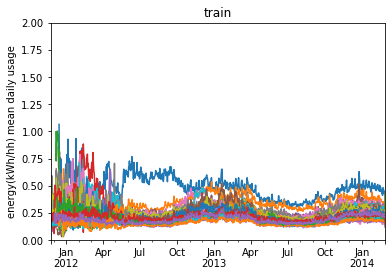

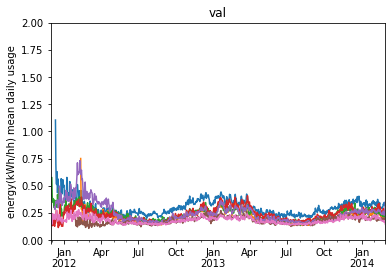

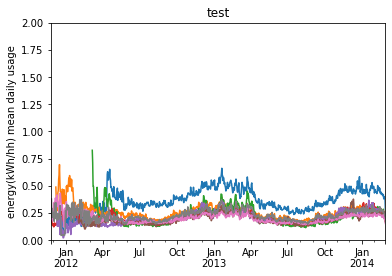

In [7]:
plt.figure()
for name,g in df_train.groupby('block'):
    g['energy(kWh/hh)'].resample('D').mean().plot(ax=plt.gca(), ylim=[0,2])
plt.title('train')
plt.ylabel('energy(kWh/hh) mean daily usage')
plt.show()

plt.figure()
for name,g in df_val.groupby('block'):
    g['energy(kWh/hh)'].resample('D').mean().plot(ax=plt.gca(), ylim=[0,2])
plt.title('val')
plt.ylabel('energy(kWh/hh) mean daily usage')
plt.show()

plt.figure()
for name,g in df_test.groupby('block'):
    g['energy(kWh/hh)'].resample('D').mean().plot(ax=plt.gca(), ylim=[0,2])
plt.title('test')
plt.ylabel('energy(kWh/hh) mean daily usage')
plt.show()

In [8]:
# df_train[['energy(kWh/hh)']].resample('30T').mean().plot(title='train', ylim=[0,3])
# df_val[['energy(kWh/hh)']].resample('30T').mean().plot(title='val', ylim=[0,3])
# df_test[['energy(kWh/hh)']].resample('30T').mean().plot(title='test', ylim=[0,3])

# Experiments

In [9]:
default_user_attrs = {
    'context_in_target': False,
    'x_dim': 17,
    'y_dim': 1,
    'vis_i': '670',
    'num_workers': 3,
    'num_context': 48 * 7,
    'num_extra_target': 48 * 2,
    'max_nb_epochs': 20,
    'min_std': 0.005,
    'grad_clip': 40,
    'batch_size': 32,
    'patience': 1,
    'max_epoch_steps': 32*600,
}
N = 5

experiments = [
    dict(name="anp-rnn",
         params={
             'det_enc_cross_attn_type': 'multihead',
             'det_enc_self_attn_type': 'multihead',
             'latent_enc_self_attn_type': 'multihead',
             'use_deterministic_path': True,
         },
         PL_MODEL_CLS=PL_ANPRNN),
    dict(name="anp-rnn_extras",
         params={
             'det_enc_cross_attn_type': 'ptmultihead',
             'det_enc_self_attn_type': 'ptmultihead',
             'latent_enc_self_attn_type': 'ptmultihead',
             'use_deterministic_path': True,
             'batchnorm': True,
             'attention_dropout': 0.2,
             'dropout': 0.2,
             'use_lvar': True,
             
         },
         PL_MODEL_CLS=PL_ANPRNN),
    dict(name="anp-rnn_extras_no_det",
         params={
             'det_enc_cross_attn_type': 'ptmultihead',
             'det_enc_self_attn_type': 'ptmultihead',
             'latent_enc_self_attn_type': 'ptmultihead',
             'use_deterministic_path': False,
             'batchnorm': True,
             'attention_dropout': 0.2,
             'dropout': 0.2,
             'use_lvar': True,
             
         },
         PL_MODEL_CLS=PL_ANPRNN),
    dict(
        name="anp-rnn_no_det",
        params={
            'use_deterministic_path': False,
        },
        PL_MODEL_CLS=PL_ANPRNN,
    ),
    dict(name="anp_c",
         PL_MODEL_CLS=PL_ANP),
    dict(
        name="np",
        PL_MODEL_CLS=PL_NP,
    ),
    dict(
        name="PL_Transformer",
        PL_MODEL_CLS=PL_Transformer,
    ),
    dict(name="TransformerSeq2Seq_PL", PL_MODEL_CLS=TransformerSeq2Seq_PL),
    dict(
        name="LSTM_PL_STD",
        PL_MODEL_CLS=LSTM_PL_STD,
    ),
    dict(
        name="LSTMSeq2Seq_PL",
        PL_MODEL_CLS=LSTMSeq2Seq_PL,
    )
]
number=-1
results = collections.defaultdict(list)

In [10]:
# Summarize results


def summarize_results(results):
    result_dfs = []
    for k in results:
        v = results[k]
        df = pd.DataFrame(v).mean()
        df.name = k+'_mean'
        df['n'] = len(v)
        result_dfs.append(df)

        df = pd.DataFrame(v).std()
        df.name = k+'_std'
        df['n'] = len(v)
        result_dfs.append(df)

    if len(result_dfs)==0:
        return None
    result_df = pd.concat(result_dfs, 1).T
    
    return result_df.sort_values('agg_test_loss').T

In [11]:
# for i in range(N):
#     for exp in experiments:
#         print(i, exp)
#         trial, trainer, model = run_trial(
#             user_attrs = default_user_attrs,
#             number=number*i*100-1000,
#             **exp)

#         name = trainer.logger.name
#         r=trainer.logger.metrics[-1]
#         if 'agg_test_loss' in r:
#             results[name].append(r)

#             display(summarize_results(results))

In [12]:
display(summarize_results(results))

None

# Manual exp

In [13]:
number=None

# Hyperparam

In [14]:
from neural_processes.train import objective
import argparse 

In [15]:
optuna_path = Path('./optuna_result')
optuna_path.mkdir(exist_ok=True)

[I 2020-04-19 20:05:10,418] Using an existing study with name 'PL_ANPRNN' instead of creating a new one.


{'number': 1, 'params': {'attention_dropout': 0.48012754200357555, 'batchnorm': False, 'dropout': 0.28108389837286674, 'hidden_dim_power': 5.0, 'latent_dim_power': 6.0, 'learning_rate': 1.1352751796833547e-06, 'n_decoder_layers': 9, 'n_det_encoder_layers': 1, 'n_latent_encoder_layers': 6, 'num_heads_power': 2.0, 'use_deterministic_path': False}, 'user_attrs': {'batch_size': 32, 'context_in_target': False, 'grad_clip': 40, 'max_epoch_steps': 19200, 'max_nb_epochs': 20, 'min_std': 0.005, 'num_context': 336, 'num_extra_target': 96, 'num_workers': 3, 'patience': 1, 'vis_i': '670', 'x_dim': 17, 'y_dim': 1}}
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
   | Name                                                                       | Type                 | Params
----------------------------------------------------------------------------------------------------------------
0  | _model                                                                     | Neur

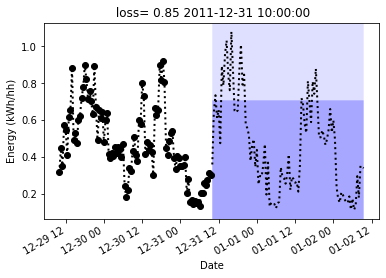

step val 0, {'agg_val_loss': 0.8388433456420898, 'log': {'agg_val_loss': 0.8388433456420898, 'agg_val_loss_p': 0.8388433456420898, 'agg_val_loss_kl': 1.7547450159582922e-09, 'agg_val_loss_mse': 0.2671003043651581, 'agg_val_loss_p_weighted': 0.15915091335773468}} {}


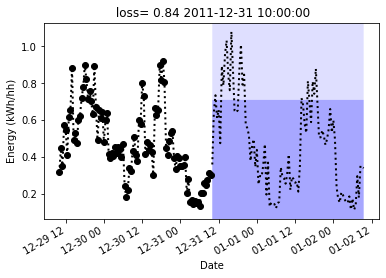

step val 599, {'agg_val_loss': 0.8246803283691406, 'log': {'agg_val_loss': 0.8246803283691406, 'agg_val_loss_p': 0.8246803283691406, 'agg_val_loss_kl': 4.942741771429837e-10, 'agg_val_loss_mse': 0.25529608130455017, 'agg_val_loss_p_weighted': 0.1565195471048355}} {}


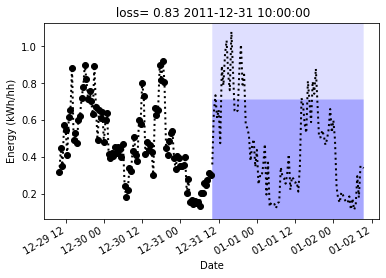

step val 1199, {'agg_val_loss': 0.8167229294776917, 'log': {'agg_val_loss': 0.8167229294776917, 'agg_val_loss_p': 0.8167229294776917, 'agg_val_loss_kl': 4.703258893457019e-10, 'agg_val_loss_mse': 0.24980510771274567, 'agg_val_loss_p_weighted': 0.15515592694282532}} {}


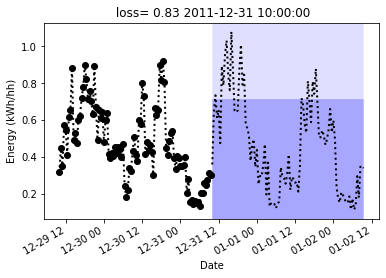

step val 1799, {'agg_val_loss': 0.8114604353904724, 'log': {'agg_val_loss': 0.8114604353904724, 'agg_val_loss_p': 0.8114604353904724, 'agg_val_loss_kl': 2.424186962279862e-10, 'agg_val_loss_mse': 0.247092604637146, 'agg_val_loss_p_weighted': 0.15417858958244324}} {}


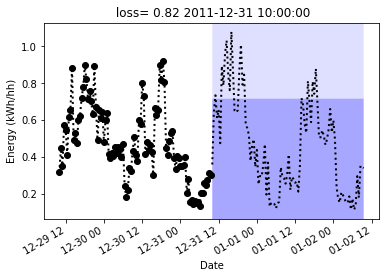

step val 2399, {'agg_val_loss': 0.8016082644462585, 'log': {'agg_val_loss': 0.8016082644462585, 'agg_val_loss_p': 0.8016082644462585, 'agg_val_loss_kl': 1.4512785417863938e-10, 'agg_val_loss_mse': 0.24019889533519745, 'agg_val_loss_p_weighted': 0.15210217237472534}} {}


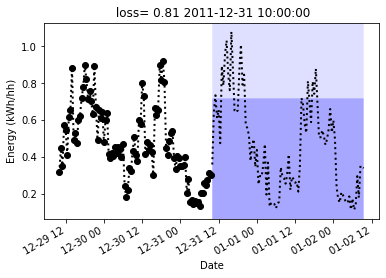

step val 2999, {'agg_val_loss': 0.7885093092918396, 'log': {'agg_val_loss': 0.7885093092918396, 'agg_val_loss_p': 0.7885093092918396, 'agg_val_loss_kl': 1.2665066217998344e-10, 'agg_val_loss_mse': 0.23077741265296936, 'agg_val_loss_p_weighted': 0.14965592324733734}} {}


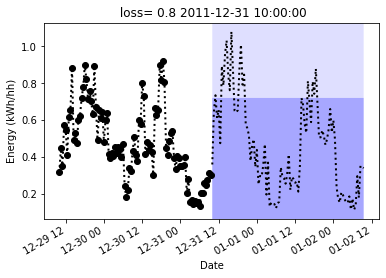

step val 3599, {'agg_val_loss': 0.7845635414123535, 'log': {'agg_val_loss': 0.7845635414123535, 'agg_val_loss_p': 0.7845635414123535, 'agg_val_loss_kl': 6.913025013544072e-11, 'agg_val_loss_mse': 0.23105168342590332, 'agg_val_loss_p_weighted': 0.14902226626873016}} {}


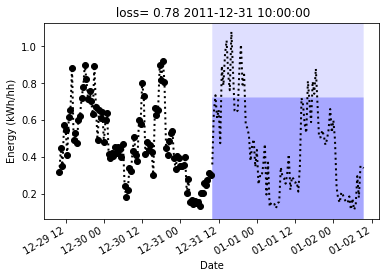

step val 4199, {'agg_val_loss': 0.7693333029747009, 'log': {'agg_val_loss': 0.7693333029747009, 'agg_val_loss_p': 0.7693333029747009, 'agg_val_loss_kl': 3.1123686961009867e-10, 'agg_val_loss_mse': 0.22292184829711914, 'agg_val_loss_p_weighted': 0.14608505368232727}} {}


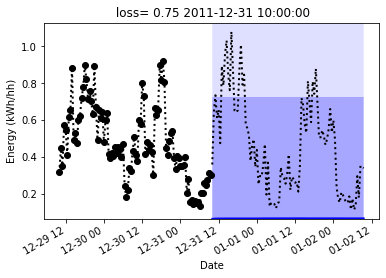

step val 4799, {'agg_val_loss': 0.7361243963241577, 'log': {'agg_val_loss': 0.7361243963241577, 'agg_val_loss_p': 0.7361243963241577, 'agg_val_loss_kl': 1.2893736078822826e-09, 'agg_val_loss_mse': 0.20348986983299255, 'agg_val_loss_p_weighted': 0.13965754210948944}} {}


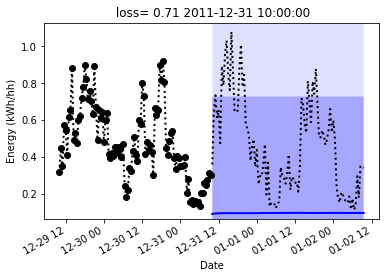

step val 5399, {'agg_val_loss': 0.6930906772613525, 'log': {'agg_val_loss': 0.6930906772613525, 'agg_val_loss_p': 0.6930906772613525, 'agg_val_loss_kl': 3.751962296405509e-09, 'agg_val_loss_mse': 0.18601135909557343, 'agg_val_loss_p_weighted': 0.13182565569877625}} {}


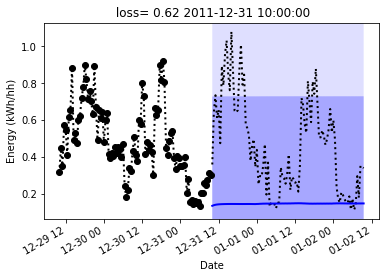

step val 5999, {'agg_val_loss': 0.6043251156806946, 'log': {'agg_val_loss': 0.6043251156806946, 'agg_val_loss_p': 0.6043251156806946, 'agg_val_loss_kl': 8.575653076547951e-09, 'agg_val_loss_mse': 0.15319955348968506, 'agg_val_loss_p_weighted': 0.11502740532159805}} {}


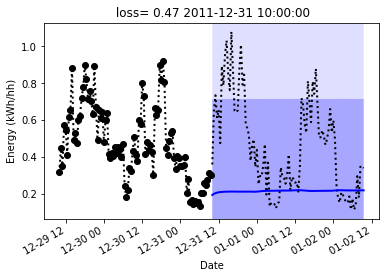

step val 6599, {'agg_val_loss': 0.4578890800476074, 'log': {'agg_val_loss': 0.4578890800476074, 'agg_val_loss_p': 0.4578890800476074, 'agg_val_loss_kl': 1.8930265355265874e-08, 'agg_val_loss_mse': 0.11670159548521042, 'agg_val_loss_p_weighted': 0.08770827203989029}} {}


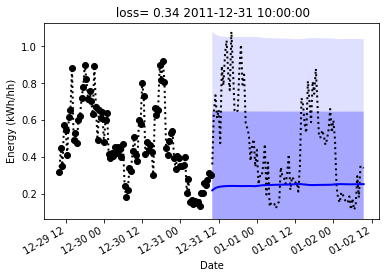

step val 7199, {'agg_val_loss': 0.32778048515319824, 'log': {'agg_val_loss': 0.32778048515319824, 'agg_val_loss_p': 0.32778042554855347, 'agg_val_loss_kl': 3.183859220712293e-08, 'agg_val_loss_mse': 0.10455664247274399, 'agg_val_loss_p_weighted': 0.06364981085062027}} {}


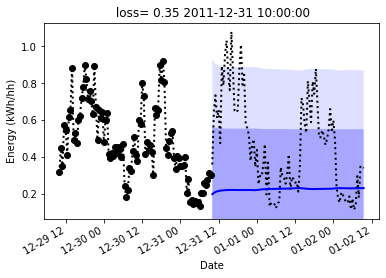

step val 7799, {'agg_val_loss': 0.3220246732234955, 'log': {'agg_val_loss': 0.3220246732234955, 'agg_val_loss_p': 0.3220246136188507, 'agg_val_loss_kl': 3.9713373922722894e-08, 'agg_val_loss_mse': 0.11114473640918732, 'agg_val_loss_p_weighted': 0.06298849731683731}} {}


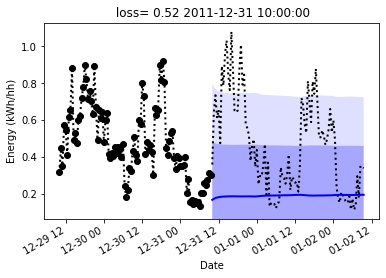

step val 8399, {'agg_val_loss': 0.4991856813430786, 'log': {'agg_val_loss': 0.4991856813430786, 'agg_val_loss_p': 0.4991856515407562, 'agg_val_loss_kl': 4.5224922473607876e-08, 'agg_val_loss_mse': 0.13010478019714355, 'agg_val_loss_p_weighted': 0.09435474872589111}} {}


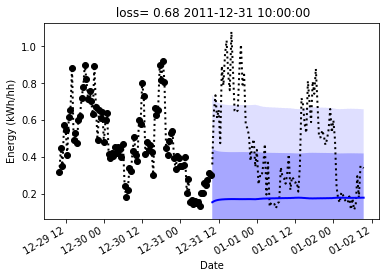

step val 8999, {'agg_val_loss': 0.646935760974884, 'log': {'agg_val_loss': 0.646935760974884, 'agg_val_loss_p': 0.6469357013702393, 'agg_val_loss_kl': 4.846742740483023e-08, 'agg_val_loss_mse': 0.13657808303833008, 'agg_val_loss_p_weighted': 0.12212863564491272}} {}
Epoch    14: reducing learning rate of group 0 to 1.1353e-07.


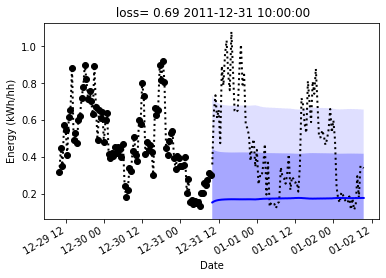

step val 9599, {'agg_val_loss': 0.6544181704521179, 'log': {'agg_val_loss': 0.6544181704521179, 'agg_val_loss_p': 0.6544181108474731, 'agg_val_loss_kl': 5.02079515740661e-08, 'agg_val_loss_mse': 0.13731487095355988, 'agg_val_loss_p_weighted': 0.1231665387749672}} {}


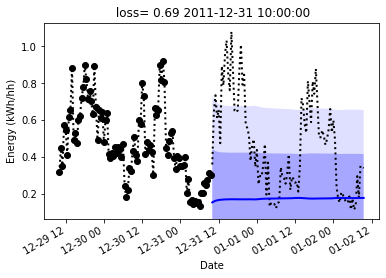

step val 10199, {'agg_val_loss': 0.6692565083503723, 'log': {'agg_val_loss': 0.6692565083503723, 'agg_val_loss_p': 0.6692565083503723, 'agg_val_loss_kl': 4.7876802966584364e-08, 'agg_val_loss_mse': 0.13852128386497498, 'agg_val_loss_p_weighted': 0.12846437096595764}} {}
Epoch    16: reducing learning rate of group 0 to 1.0000e-07.


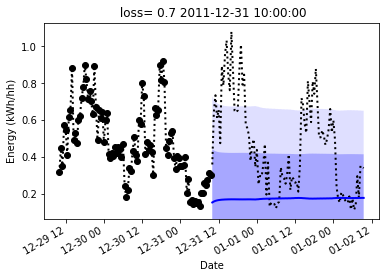

step val 10799, {'agg_val_loss': 0.692561149597168, 'log': {'agg_val_loss': 0.692561149597168, 'agg_val_loss_p': 0.692561149597168, 'agg_val_loss_kl': 5.060634933329311e-08, 'agg_val_loss_mse': 0.14036399126052856, 'agg_val_loss_p_weighted': 0.1309993863105774}} {}


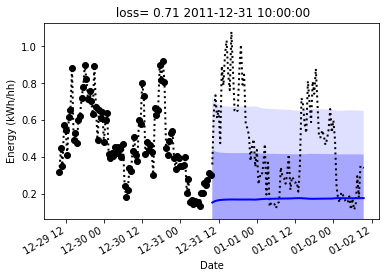

step val 11399, {'agg_val_loss': 0.6806090474128723, 'log': {'agg_val_loss': 0.6806090474128723, 'agg_val_loss_p': 0.6806090474128723, 'agg_val_loss_kl': 4.959863986186974e-08, 'agg_val_loss_mse': 0.13892897963523865, 'agg_val_loss_p_weighted': 0.128485769033432}} {}


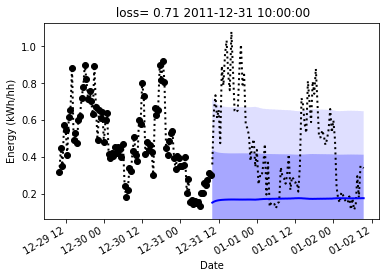

step val 11999, {'agg_val_loss': 0.6943409442901611, 'log': {'agg_val_loss': 0.6943409442901611, 'agg_val_loss_p': 0.6943409442901611, 'agg_val_loss_kl': 5.02997039575348e-08, 'agg_val_loss_mse': 0.13999043405056, 'agg_val_loss_p_weighted': 0.13139313459396362}} {}

Loading checkpoint lightning_logs/PL_ANPRNN/version_1/_ckpt_epoch_12.ckpt


INFO:predict_heading2:step 12000, {'agg_test_loss': 0.03267616033554077, 'log': {'agg_test_loss': 0.03267620876431465, 'agg_test_loss_p': 0.03267616033554077, 'agg_test_loss_kl': 5.183278162235183e-08, 'agg_test_loss_mse': 0.05047878623008728, 'agg_test_loss_p_weighted': 0.007406601216644049}}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------

logger.metrics [{'agg_test_loss': 0.03267620876431465, 'agg_test_loss_p': 0.03267616033554077, 'agg_test_loss_kl': 5.183278162235183e-08, 'agg_test_loss_mse': 0.05047878623008728, 'agg_test_loss_p_weighted': 0.007406601216644049}]


[W 2020-04-19 20:31:56,696] Setting status of trial#1 as TrialState.FAIL because of the following error: KeyError('test_loss')
Traceback (most recent call last):
  File "/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/optuna/study.py", line 569, in _run_trial
    result = func(trial)
  File "/media/wassname/Storage5/projects2/3ST/attentive-neural-processes/neural_processes/train.py", line 84, in objective
    return model.logger.metrics[-1]["test_loss"]
KeyError: 'test_loss'


KeyError: 'test_loss'

In [16]:
for PL_MODEL_CLS in [PL_ANPRNN, TransformerSeq2Seq_PL]:
    name = str(PL_MODEL_CLS.__name__)
    func = functools.partial(objective,
                             PL_MODEL_CLS=PL_MODEL_CLS,
                             name=name,
                             user_attrs=default_user_attrs)

    parser = argparse.ArgumentParser(description='PyTorch Lightning example.')
    parser.add_argument(
        '--pruning',
        '-p',
        action='store_true',
        help='Activate the pruning feature. `MedianPruner` stops unpromising '
        'trials at the early stages of training.')
    args = parser.parse_args(['-p'])

    pruner = optuna.pruners.MedianPruner(
        n_warmup_steps=1,
        n_startup_trials=6) if args.pruning else optuna.pruners.NopPruner()
    pruner = optuna.pruners.PercentilePruner(75.0)

    study = optuna.create_study(direction='minimize',
                                pruner=pruner,
                                storage=f'sqlite:///{optuna_path}/{name}.db',
                                study_name=name,
                                load_if_exists=True)

    study.optimize(func=func,
                   n_trials=200,
                   timeout=pd.Timedelta('0.5d').total_seconds())

    print('Number of finished trials: {}'.format(len(study.trials)))

    print('Best trial:')
    trial = study.best_trial

    print('  Value: {}'.format(trial.value))

    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

    # shutil.rmtree(MODEL_DIR)

    df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
    print(df.sort_values('value'))

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')